In [1]:
import numpy as np
import matplotlib.pyplot as plt
from laspec import convolution
import os
from astropy.io import fits
#from pyexspec.io import iospec1d
from laspec import normalization
import joblib
from astropy.table import Table
from pyexspec.utils import rvcorr_spec

import warnings
warnings.filterwarnings('ignore')

The flux standard stars can by found in [iraf](https://github.com/joequant/iraf/blob/master/noao/lib/onedstds/README) stardard star
or pypeit/data/standards/calspe

In [2]:
from pyexspec.utils import broadspc

def normflux(wave, flux, p=8e-07, q=0.56, lu=(-1, 3), binwidth=100, niter=3):
    '''
    returns:
    ---------------                                                                                                                                                                  
    flxnorm: [2D array]
    '''
    flxnorm = normalization.normalize_spectrum_spline(wave, flux, p=p, q=q, lu=lu, binwidth=binwidth, niter=niter)
    return flxnorm

def norm_flux(wave, flux, wave_obs, R, R0, vsini, rv=0,  epsilon=0.2, N =3):
    '''
    returns:
    ---------------
    fluxout: [1D array]
    fluxnorm: [1D array]
    '''
    wave = rvcorr_spec(wave, rv, returnwvl=True)
    wave_obs, fluxout = broadspc(wave, flux, R, vsini, epsilon=epsilon, R0=R0, waveobs=wave_obs)
    fluxnorm = normflux(wave_obs, fluxout)
    return fluxout, fluxnorm[0]

# Re-define the class iospec1d for setting default wave, flux and flux error

In [3]:
from pyexspec.io import iospec1d
class iospec1d(iospec1d):
    
    
    def readspec1d_dump(self, filename, wave_key = 'wave_solu',
                       flux_key = 'spec_extr_divide_flat', flux_err_key = 'err_extr_divide_flat'):
        '''
        Read 1D spectrum from the dump file extraceted by pyexspec
        returns:
        wave, flux, flux_err
        '''
        dumpdic = joblib.load(filename)
        self.dumpdic = dumpdic
        wave = dumpdic[wave_key][0][::-1]  
        flux = dumpdic[flux_key][::-1] 
        flux_err = dumpdic[flux_err_key][::-1]
        blaze = dumpdic['blaze'][0]
        blaze = blaze[::-1]
        blaze = blaze/np.median(blaze)
        #flux = flux/blaze
        #flux_err = flux_err/blaze
        self.blaze = blaze
        self.wave = wave
        self.flux = flux
        self.flux_err = flux_err
        return wave, flux, flux_err
    
    
    def normlize(self, wave=None, flux=None, flux_err=None):
        '''
        flux_norm, flux_err_norm, flux_cont
        '''
        if wave is None: wave = self.wave
        if flux is None: flux = self.flux
        if flux_err is None: flux_err = self.flux_err
        flux_norm, flux_cont = normalization.normalize_spectrum_spline(wave, flux, p=8e-07, q=0.56, lu=(-1, 3), binwidth=100, niter=3)
        flux_err_norm = flux_err/flux_cont
        self.flux_norm = flux_norm
        self.flux_cont = flux_cont
        self.flux_err_norm = flux_err_norm
        return flux_norm, flux_err_norm, flux_cont       
        

In [4]:
from glob import glob

dire = '/share/data/lijiao/Documents/sdOB/example/lan11/data/'
dire_dump = os.path.join(dire, 'spec/P200_DBPS/20220219_rawdata/blue/dump_bgdeg2/')


# Finding the standard flux star
- blue0056 is the spectrum of [HD 104687](http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=HD+104687&submit=SIMBAD+search) which the atmosphere parameters can be found in Gaia dr3

- ra, dec = (180.8206004296600 +33.6170836241200)
- 12 03 16.9441031184 +33 37 01.501046832
- Teff = 6781.511
- logg = 4.0868
- [M/H] = -0.3006

In [5]:
from astroquery.gaia import Gaia
query = '''
   SELECT
   *
   FROM gaiadr3.gaia_source as gs
   where
      1=CONTAINS(POINT('ICRS', gs.ra, gs.dec),
                 CIRCLE('ICRS', {ra}, {dec}, {radius}))
   and parallax > 0
   '''.format(**{ 'ra': 180.820600, 'dec': +33.6170836,
                  'radius': 3/3600})



#job_obj = Gaia.launch_job_async(query=query,
#                              output_file='../data/Gaia/HD104687.fits',
#                              output_format="fits",
#                              verbose=False,
#                              dump_to_file=True,
#                              background=False)
#tab_gaia= job_obj.get_data()
tab_gaia_HD104687 = Table.read(os.path.join(dire, 'Gaia/HD104687.fits'))
tab_gaia_HD104687['teff_gspphot', 'logg_gspphot', 'mh_gspphot']


query = '''
   SELECT
   *
   FROM gaiadr3.astrophysical_parameters_supp as ap
   where
        ap.source_id = {source_id}
   '''.format(**{ 'source_id': tab_gaia_HD104687['source_id'][0]})

#job_obj = Gaia.launch_job_async(query=query,
#                              output_file='../data/Gaia/HD104687_astrophysical_parameters.fits',
#                              output_format="fits",
#                              verbose=False,
#                              dump_to_file=True,
#                              background=False)

from astropy.table import join
_tab = Table.read(os.path.join(dire, 'Gaia/HD104687_astrophysical_parameters.fits'))
tab_gaia_HD104687 = join(tab_gaia_HD104687, _tab, keys=['solution_id', 'source_id'])

In [6]:
tab_gaia_HD104687['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'radius_gspphot_a', 'radius_gspphot_phoenix', 'radius_gspphot_marcs']

teff_gspphot,logg_gspphot,mh_gspphot,radius_gspphot_a,radius_gspphot_phoenix,radius_gspphot_marcs
K,log(cm.s**-2),'dex',solRad,solRad,solRad
float32,float32,float32,float32,float32,float32
6781.511,4.0868,-0.3006,1.7069,1.7114,1.7043


# load observation spectrum of standard star

Text(0.5, 0, 'Wavelength (${\\rm \\AA}$)')

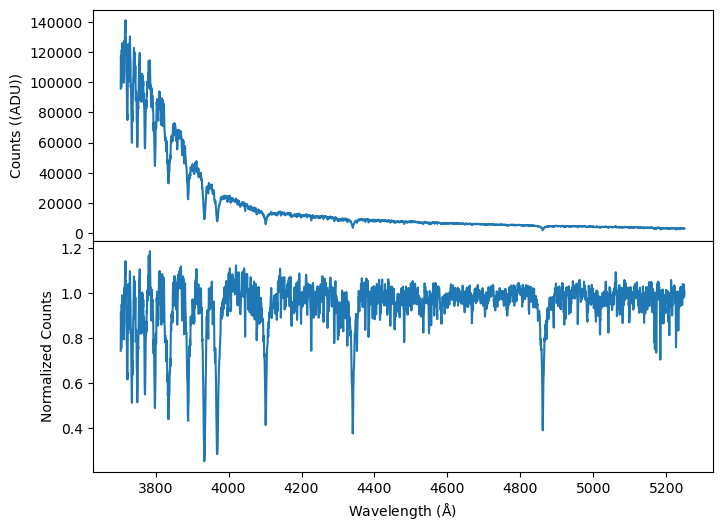

In [7]:
fname_filelist = os.path.join(dire_dump, '../TABLE/filelist_table.csv')
tab_filelist = Table.read(fname_filelist)
tab_filelist = tab_filelist[tab_filelist['type']=='star']

fitsname = 'blue0056.fits'
_ind = tab_filelist['filename'] == fitsname
dumpname = os.path.join(dire_dump, f'star-{fitsname}.dump')
stdobsspec = iospec1d()
wave, flux, fluxerr = stdobsspec.readspec1d_dump(dumpname, wave_key = 'wave_solu')
## normalize the standard star spectrum
stdobsspec.normlize()

fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True)
plt.subplots_adjust(hspace=0)
plt.sca(axs[0])
plt.plot(stdobsspec.wave, stdobsspec.flux)
plt.ylabel('Counts ((ADU))')
plt.sca(axs[1])
plt.plot(stdobsspec.wave, stdobsspec.flux_norm)
plt.ylabel('Normalized Counts')
plt.xlabel(r'Wavelength (${\rm \AA}$)')

# load synthectic spectrum of standard star

In [8]:
fname_stdsyn = os.path.join(dire, 'spec/stdstar_synthetic/HD104687.spc')
wave_std_syn, flux_std_syn = np.loadtxt(fname_stdsyn).T
flux_std_syn = flux_std_syn*np.pi

In [9]:
class load_spec_syn(iospec1d):
    
    def __init__(self, wave, flux):
        self.wave_syn = wave
        self.flux_syn = flux
        #self.flux_norm_sp_true = flux_norm
        
    #def normalize(self, wave=None, flux=None):
    #    if wave is None: wave = self.wave_sp
    #    if flux is None: flux = self.flux_sp
    #    self.flux_norm_lasp, self.flux_cont_lasp = normalization.normalize_spectrum_spline(wave, flux)
    
    
    def rvcorr_syn(self, rv, wave=None):
        if wave is None: wave = self.wave_syn
        self.wave_syn_rvcorr = rvcorr_spec(self.wave_syn, rv, returnwvl=True)
        

    def broad_syn(self, R=3000, vsini=0, waveobs=None):
        '''
        broad synthectic sepctrum
        '''
        wsp, fsp = self.wave_syn, self.flux_syn
        flux_broad, flux_broaden_norm = norm_flux(wsp, fsp, wsp, R , 300000, vsini)
        self.flux_broad_syn = flux_broad
        self.flux_broad_norm_syn = flux_broaden_norm
        if waveobs is not None:
            flux_broad_syn_obs = np.interp(waveobs, wsp, flux_broaden_norm)
            self.waveobs = waveobs
            self.flux_broad_norm_syn_obs = flux_broad_syn_obs

        
    def lnlike(self, theta, waveobs, fluxobs_norm):
        '''
        synspecxtgrid [class]
        '''
        R, vsini = theta
        vsini = 0
        if R < 1000 or R >10000: return -np.inf
        if (vsini < 0) or (vsini > 150) or (vsini > 0 and vsini < 5): return -np.inf
        self.broad_syn(R=R, vsini=vsini, waveobs=waveobs)
        fluxsyn = self.flux_broad_norm_syn_obs
        chi2 = -0.5*np.sum((fluxsyn - fluxobs_norm)**2)
        return chi2

stdsynspec = load_spec_syn(wave_std_syn, flux_std_syn)

# find the best resolution

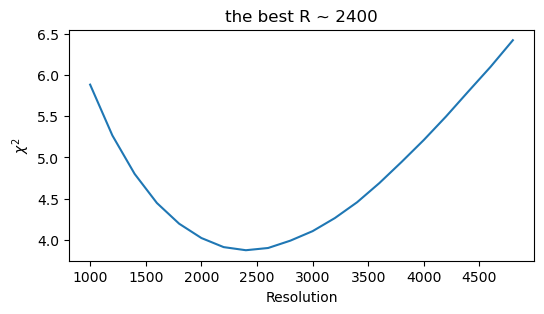

In [10]:
%matplotlib inline

Rs = np.arange(1000, 5000, 200) 
chi2s = [stdsynspec.lnlike([_, 0], stdobsspec.wave, stdobsspec.flux_norm) for _ in Rs]

plt.subplots(1,1, figsize=(6,3))
plt.plot(Rs, -2*np.array(chi2s))
plt.xlabel('Resolution')
plt.ylabel(r'$\chi^2$')
plt.title(f'the best R ~ {Rs[np.argmax(chi2s)]}')
plt.show()

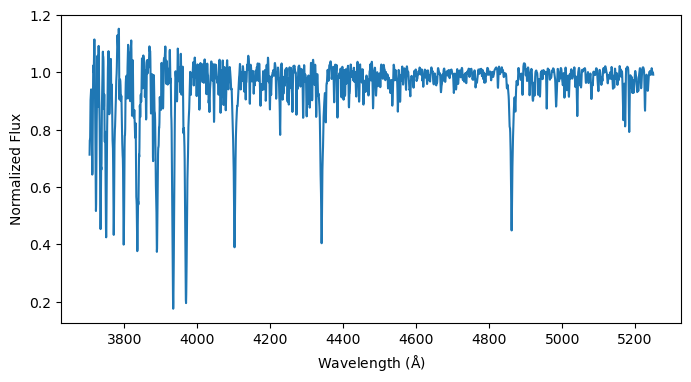

In [10]:
stdsynspec.broad_syn(R=2400, vsini=0, waveobs=stdobsspec.wave)

fig, axs = plt.subplots(1,1, figsize=(8,4), sharex=True)
plt.plot(stdsynspec.waveobs, stdsynspec.flux_broad_norm_syn_obs)
plt.ylabel('Normalized Flux')
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.show()

# measure the RV of spectrum of the standard star

- note using the wavelength without heliocentric (or barycentric) correction

- shift the synthetic spetrum to observation of standard star

In [11]:
from laspec.ccf import RVM
wave_mod = stdsynspec.wave_syn
_ind = wave_mod < 6000
flux_mod = stdsynspec.flux_broad_norm_syn
flux_mod = np.array([flux_mod[_ind]])
rvm_stdstar = RVM(np.array([1, 1]), wave_mod[_ind], flux_mod )

rv_stdstar = rvm_stdstar.measure(stdobsspec.wave, stdobsspec.flux_norm, flux_err=stdobsspec.flux_err_norm, nmc=100, rv_grid=(-600, 600, 0.1),)
print('rv of stdstar', rv_stdstar)
stdsynspec.rvcorr_syn(rv_stdstar['rv_opt'])

@RVM: initializing Radial Velocity Machine (RVM)...
rv of stdstar {'rv_opt': 5.000000000137561, 'rv_err': 1.0, 'rv_best': 5.000000000137561, 'ccfmax': 0.9470751163897958, 'success': True, 'imod': 0, 'pmod': array([1, 1]), 'status': 0, 'rv_pct': array([4.71333913, 5.        , 5.38176284])}


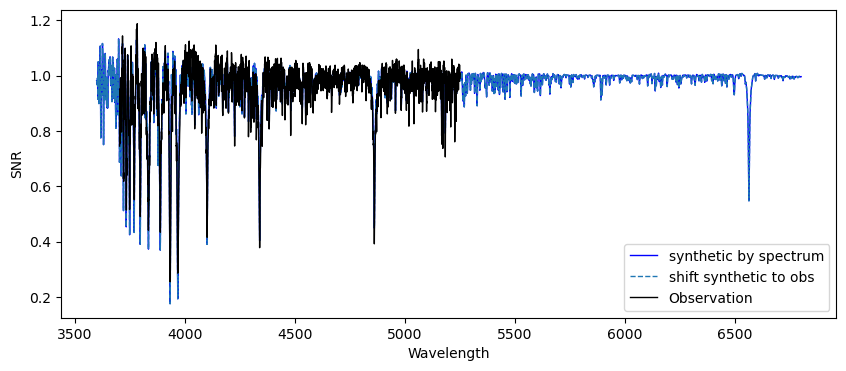

In [12]:
%matplotlib inline

fig, axs = plt.subplots(1,1,figsize=(10,4))
plt.plot(stdsynspec.wave_syn, stdsynspec.flux_broad_norm_syn, label='synthetic by spectrum', lw=1, color='b')
plt.plot(stdsynspec.wave_syn_rvcorr, stdsynspec.flux_broad_norm_syn, label='shift synthetic to obs ', lw=1, ls='--')
plt.plot(stdobsspec.wave, stdobsspec.flux_norm, label='Observation', lw=1, color='k')
plt.ylabel('SNR')
plt.xlabel('Wavelength')
plt.legend()
plt.show()

In [13]:
tab_gaia_HD104687

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,libname_best_gspphot,teff_gspphot_marcs,teff_gspphot_marcs_lower,teff_gspphot_marcs_upper,logg_gspphot_marcs,logg_gspphot_marcs_lower,logg_gspphot_marcs_upper,mh_gspphot_marcs,mh_gspphot_marcs_lower,mh_gspphot_marcs_upper,distance_gspphot_marcs,distance_gspphot_marcs_lower,distance_gspphot_marcs_upper,azero_gspphot_marcs,azero_gspphot_marcs_lower,azero_gspphot_marcs_upper,ag_gspphot_marcs,ag_gspphot_marcs_lower,ag_gspphot_marcs_upper,abp_gspphot_marcs,abp_gspphot_marcs_lower,abp_gspphot_marcs_upper,arp_gspphot_marcs,arp_gspphot_marcs_lower,arp_gspphot_marcs_upper,ebpminrp_gspphot_marcs,ebpminrp_gspphot_marcs_lower,ebpminrp_gspphot_marcs_upper,mg_gspphot_marcs,mg_gspphot_marcs_lower,mg_gspphot_marcs_upper,radius_gspphot_marcs,radius_gspphot_marcs_lower,radius_gspphot_marcs_upper,logposterior_gspphot_marcs,mcmcaccept_gspphot_marcs,teff_gspphot_phoenix,teff_gspphot_phoenix_lower,teff_gspphot_phoenix_upper,logg_gspphot_phoenix,logg_gspphot_phoenix_lower,logg_gspphot_phoenix_upper,mh_gspphot_phoenix,mh_gspphot_phoenix_lower,mh_gspphot_phoenix_upper,distance_gspphot_phoenix,distance_gspphot_phoenix_lower,distance_gspphot_phoenix_upper,azero_gspphot_phoenix,azero_gspphot_phoenix_lower,azero_gspphot_phoenix_upper,ag_gspphot_phoenix,ag_gspphot

In [14]:
tab_gaia_HD104687['teff_gspphot', 'logg_gspphot', 'radius_gspphot_marcs']

teff_gspphot,logg_gspphot,radius_gspphot_marcs
K,log(cm.s**-2),solRad
float32,float32,float32
6781.511,4.0868,1.7043


In [15]:
tab_gaia_HD104687['teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower', 'logg_gspphot', 'logg_gspphot_upper', 'logg_gspphot_lower', 'radius_gspphot_marcs', 'parallax', 'parallax_error']

teff_gspphot,teff_gspphot_upper,teff_gspphot_lower,logg_gspphot,logg_gspphot_upper,logg_gspphot_lower,radius_gspphot_marcs,parallax,parallax_error
K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),solRad,mas,mas
float32,float32,float32,float32,float32,float32,float32,float64,float32
6781.511,6783.5146,6780.0225,4.0868,4.0915,4.0832,1.7043,5.1027098099929145,0.017685879


In [16]:
keys = ['teff_gspphot', 'logg_gspphot', 'radius_gspphot_marcs', 'parallax']
teff, logg, R, parallax = [tab_gaia_HD104687[_][0] for _ in keys]
ra, dec = [tab_gaia_HD104687[_][0] for _ in ['ra', 'dec']]

# Calibrate flux

In [17]:
from pyexspec.fluxcalibrate import Fcalibrate

# Modifying num_sigclip, deg of function ffcalib.standard_zeropoint_Poly1DFitter to obatain good calibrating rate

[INFO]    ::  Masking bad pixels
[INFO]    ::  Masking edges
[INFO]    ::  Masking Below the atmospheric cutoff
[INFO]    :: Masking hydrogen recombination lines
[INFO]    ::  Masking Balmer
[INFO]    ::  Masking Paschen
[INFO]    ::  Masking Brackett
[INFO]    ::  Masking Pfund
[INFO]    :: Your spectrum is bluer than 9100A, only optical telluric regions are masked.
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[WARNING] :: Maximum number of iterations maxiter=10 reached in robust_polyfit_djs
[INFO]    :: Replacing bspline fit with polyfit over Hydrogen Recombination line regions
[INFO]    ::  This is the standard pixel: 0.55 Å
[INFO]    ::  This is the standard resolution element: 1.79 Å
[INFO]    ::  Breakpoint spacing: 7.16 pixels
[INFO]    :: Initialize bspline for flux calibration
[INFO]    :: Bspline fit on zeropoint. 


  |-@grating_equation: iter-1 	484 lines kicked, 2350 lines left, rms=0.04611 A
  |-@grating_equation: iter-2 	830 lines kicked, 1520 lines left, rms=0.02220 A
  |-@grating_equation: iter-3 	617 lines kicked, 903 lines left, rms=0.01209 A
  |-@grating_equation: iter-4 	375 lines kicked, 528 lines left, rms=0.00678 A
  |-@grating_equation: iter-5 	213 lines kicked, 315 lines left, rms=0.00390 A
  |-@grating_equation: iter-5 	124 lines kicked, 315 lines left, rms=0.00224 A


[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...


Text(0, 0.5, 'Flux $\\times 10^{17}$ (erg/s/cm$^2$/$\\AA$)')

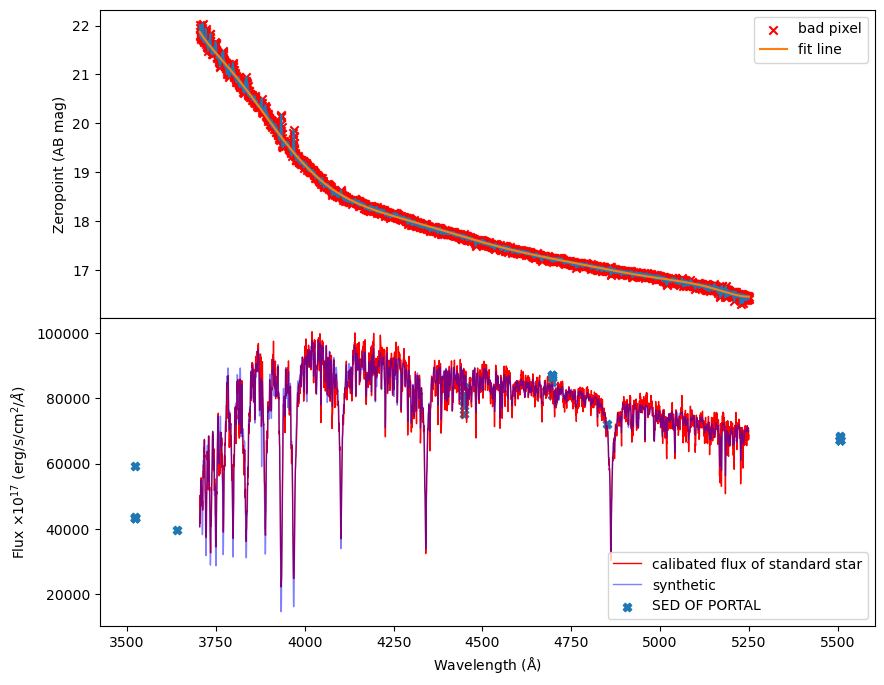

In [18]:
from astropy.coordinates import EarthLocation

fname_port_std = os.path.join(dire, '../ipynb/speedysedfit/HD104687/portalsed.csv')
tab_portal_std = Table.read(fname_port_std)
stdobs = stdobsspec
stdsyn = stdsynspec
site = EarthLocation.of_site('Palomar')
longitude = site.lon.deg
latitude = site.lat.deg
height = site.height.value
longitude, latitude, height
extinctfilepar='palomarextinct.dat'
exptime_std = stdobsspec.dumpdic['header']['exptime']
airmass_std = np.float(stdobsspec.dumpdic['header']['airmass'])


ffcalib = Fcalibrate(waveobs=None, fluxobs=None, fluxobs_err=None,
                  waveobs_std=stdobs.wave, fluxobs_std=stdobs.flux, fluxobs_std_err= stdobs.flux_err,
                  wavesyn= stdsyn.wave_syn_rvcorr, fluxsyn= stdsyn.flux_broad_syn
                  )

std_dict = ffcalib.stellar_model(R, parallax, 'F2', 9.33, wave_syn=None, flux_syn=None, Ebv=None)
zeropoint_data, zeropoint_data_gpm, zeropoint_fit, zeropoint_fit_gpm =\
        ffcalib.standard_zeropoint(exptime_std, airmass_std, longitude, latitude, extinctfilepar='palomarextinct.dat',
                           wave=None, counts=None, counts_ivar=None, counts_mask=None, flam_true = None,
                           maxiter=35, upper=2, lower=2, polyorder=10,
                           balm_mask_wid=5., nresln=4, resolution=2500.,
                           polycorrect=True, polyfunc=False, debug=False
                          )
ffcalib.standard_zeropoint_Poly1DFitter(wave=None, zeropoint_data=None, zeropoint_data_gpm=None, 
                                num_sigclip=1, deg=10, min_select=400, verbose=True)

wave_obs, counts, counts_ivar = stdobs.wave, stdobs.flux, 1/stdobs.flux_err**2
Flam, Flam_err, mask_good= ffcalib.calibrateflux(exptime_std, wave_obs, counts, counts_ivar,
                         PolyFitter=None, wave_zp=None, zeropoint=None, tellmodel=None, extinct_correct=False,
                         airmass=airmass_std, longitude=None, latitude=None, extinctfilepar='palomarextinct.dat',
                        extrap_sens=False, use_PolyFitter=True, show=False)

fig, axs = plt.subplots(2,1,figsize=(10,8), gridspec_kw={'height_ratios': [1,1]}, sharex=True)
plt.subplots_adjust(hspace=0)
plt.sca(axs[0])
plt.plot(ffcalib.waveobs_std, zeropoint_data)
_ind =~ffcalib.zeropoint_fit_indselect_Poly1DFit
plt.scatter(ffcalib.waveobs_std[_ind], zeropoint_data[_ind], label='bad pixel', marker='x', color='r')
plt.plot(ffcalib.waveobs_std, ffcalib.zeropoint_Poly1DFitter(ffcalib.waveobs_std), label='fit line')
plt.legend()
plt.ylabel('Zeropoint (AB mag)')

plt.sca(axs[1])
flam_syn = np.interp(wave_obs, ffcalib.lam_syn, ffcalib.flam_syn)
plt.plot(wave_obs, Flam, label='calibated flux of standard star', lw=1, color='r')
plt.plot(wave_obs, flam_syn, label='synthetic', color='b',lw=1,alpha=0.5)
_ind = (tab_portal_std['wave_eff'] >3500) & (tab_portal_std['wave_eff'] <6000)
plt.scatter(tab_portal_std[_ind]['wave_eff'], tab_portal_std[_ind]['flux']*1.e17, marker='X', label='SED OF PORTAL')
plt.legend(loc=4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux $\times 10^{17}$ (erg/s/cm$^2$/$\AA$)')

# show the spectrum before calibrating flux

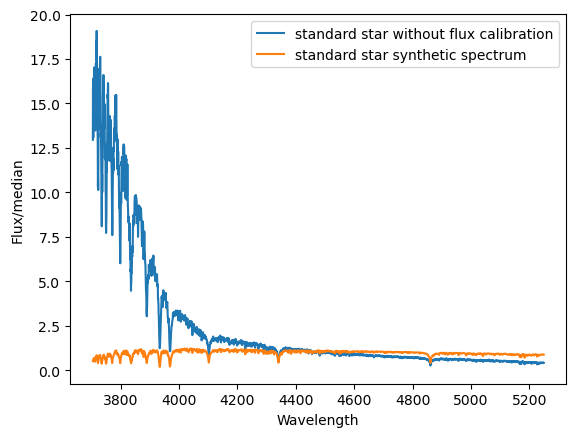

In [19]:
fig, ax = plt.subplots(1,1)
plt.plot(stdobsspec.wave, stdobsspec.flux/np.median(stdobsspec.flux), label='standard star without flux calibration')
_flux = np.interp(stdobsspec.wave, stdsyn.wave_syn_rvcorr, stdsyn.flux_broad_syn)
plt.plot(stdobsspec.wave, _flux/np.median(_flux), label='standard star synthetic spectrum')

plt.ylabel('Flux/median')
plt.xlabel('Wavelength')
plt.legend()

# find fits of lan11

In [20]:
from astropy.coordinates import SkyCoord, angular_separation
from pypeit.core.wave import geomotion_velocity
from astropy.time import Time, TimeDelta
from astropy import units
coord = SkyCoord(tab_filelist['ra'], tab_filelist['dec'], unit=(units.hourangle, units.deg))
#coord_lan11 = SkyCoord(ra = 90.12908507755, dec = 29.1486286976200, unit="deg")
coord_lan11 = SkyCoord('06:00:31.70', '+29:09:04.4', unit=(units.hourangle, units.deg))
dis_lan11 = angular_separation(coord_lan11.ra, coord_lan11.dec, coord.ra, coord.dec).to('deg').value



_ind_lan11 = dis_lan11 < 10/3600
tab_star_lan11 = tab_filelist[_ind_lan11]
#tab_star_lan11 = Table.read('../data/spec/P200_DBPS/20220219_rawdata/blue/table_rv_lan11_pyexspec.csv')

In [21]:
site2 = EarthLocation.from_geodetic(lat=33.356*units.deg, lon=-116.863*units.deg, height=1706*units.m) #P200 

In [22]:
def write2fits(wave, flux, fluxerr, mask_bad, header, fileout):
    from astropy.table import Table, Column
    table = fits.BinTableHDU.from_columns([
                    fits.Column(name='wave',  format='E', unit ='A',  array=np.array(wave, dtype=np.float32)),
                    fits.Column(name='flux',format='E',unit ='1.e17 egr/s/cm2/A', array=np.array(flux, dtype=np.float32)),
                    fits.Column(name='error',format='E', unit ='1.e17 egr/s/cm2/A',array=np.array(fluxerr, dtype=np.float32)),
                    fits.Column(name='mask',format='I', unit ='bool',array=np.array(mask_bad, dtype=np.int))
                                         ])
    table.header['TTYPE1'] = ('wave', 'barycentric correction in Air')
    table.header['TTYPE4'] = ('mask', '1 is bad pixel')
    data0 = np.array([np.nan],dtype=np.float32)
    hdu = fits.PrimaryHDU(data0)
    hdu.header = header
    hdul = fits.HDUList([hdu, table])
    hdul.writeto(fileout, overwrite=True)

- load PORTAL SED of standard star

In [23]:
fname_portal = os.path.join(dire, '../ipynb/speedysedfit/HD104687/portalsed_La11.csv')
tab_portal_lan11 = Table.read(fname_portal)

[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: App

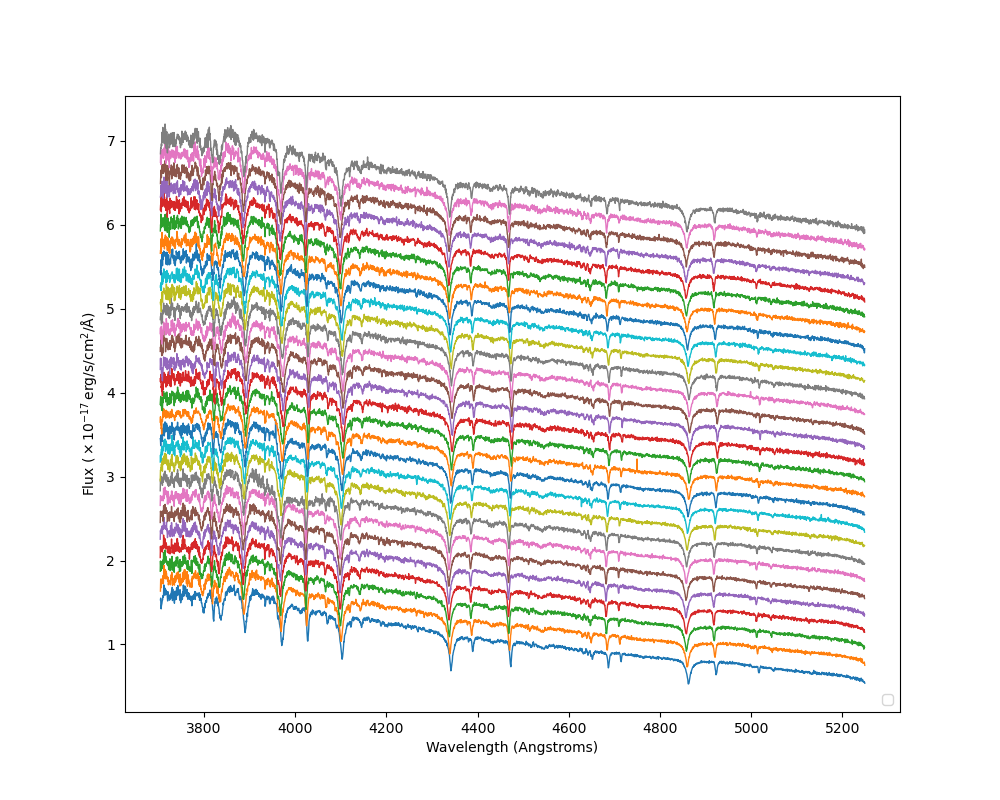

In [42]:
%matplotlib widget
fig, axs = plt.subplots(1,1,figsize=(10,8), )
for _i, _tab in enumerate(tab_star_lan11):
    _fitsname = _tab['filename']
    _dumpname = os.path.join(dire_dump, f'star-{_fitsname}.dump')
    _starspec = iospec1d()
    _wave, _counts, _fluxerr = _starspec.readspec1d_dump(_dumpname, wave_key = 'wave_solu')
    
    if 'blue0035.fits' in _dumpname:
        _counts = _starspec.dumpdic['spec_sum'][::-1]/_starspec.blaze
        _fluxerr = _starspec.dumpdic['err_sum'][::-1]/_starspec.blaze
    _counts_ivar = 1/_fluxerr**2
    exptime = _starspec.dumpdic['header']['exptime']
    airmass = np.float(_starspec.dumpdic['header']['airmass'])
    Flam, Flam_err,  gpm_star = ffcalib.calibrateflux(exptime, _wave, _counts, _counts_ivar,
                         PolyFitter=None, wave_zp=None, zeropoint=None, tellmodel=None, extinct_correct=False,
                         airmass=airmass, longitude=None, latitude=None, extinctfilepar='palomarextinct.dat', 
                        extrap_sens=False, use_PolyFitter=True)
    #plt.plot(_wave, Flam/np.median(Flam)+_i*0.2, lw=1, color='b')
    #plt.plot(_wave, Flam/Flam_err)
    ### write fits
    _wave =_starspec.dumpdic['wave_solu_barycorr'][0][::-1]
    _ind = tab_rv['filename'] == _fitsname
    _flux_norm, _flux_err_norm, _flux_cont = _starspec.normlize(wave=_wave, flux=Flam, flux_err=Flam_err)
    plt.plot(_wave, Flam/np.median(Flam)+_i*0.2, lw=1)
    _header = _starspec.dumpdic['header']
    #barycorr.append(_starspec.dumpdic['barycorr'])
    snr = np.median(Flam/Flam_err)
    bjd = _starspec.dumpdic['bjd_shut'] +exptime/2/3600/24 -2457000
    _header['BTJD'] = (bjd, 'BJD-2457000')
    _header['SNR'] = (snr, 'median SNR of pixels')
    fitsout = os.path.join(dire,  'spec/P200toXiong', f'star-{_fitsname[:-5]}_1d.fits')
    write2fits(_wave, Flam, Flam_err, ~gpm_star, _header, fitsout)


_tab = tab_portal_lan11
_ind = (_tab['wave_eff'] >3500) & (_tab['wave_eff'] <6000)
#plt.scatter(_tab[_ind]['wave_eff'], _tab[_ind]['flux']*1.e17, marker='X', label='SED OF PORTAL')
plt.legend(loc=4)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel(r'Flux (${\rm \times 10^{-17}\, erg/s/cm^2/\AA}$)')
plt.show()

[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...
[INFO]    :: Applying extinction correction
[INFO]    :: Extinction data covered the whole spectra. Applying correction...


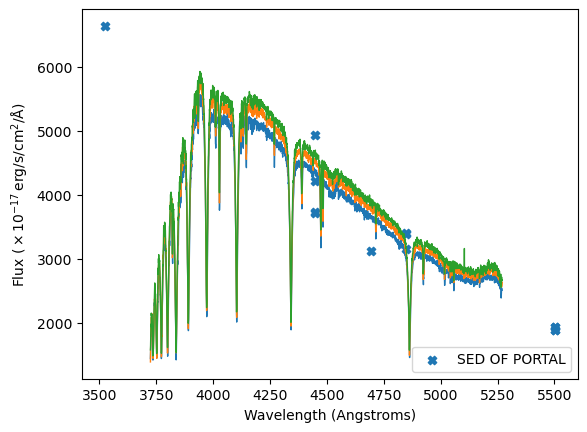

In [26]:
# calibrate Feige 64
#from pyexspec.utils.spectools import 

dire_dump_fg64 = '/share/data/lijiao/Documents/sdOB/example/Feige64/data/spec/P200_rawdata/dump_bgdeg2/'

dumplits = glob(os.path.join(dire_dump_fg64, 'star-*.dump'))

for _dumpname in dumplits:
    _basename = os.path.basename(_dumpname)
    _starspec = iospec1d()
    _wave, _counts, _fluxerr = _starspec.readspec1d_dump(_dumpname, wave_key = 'wave_solu')
    _counts_ivar = 1/_fluxerr**2
    exptime = _starspec.dumpdic['header']['exptime']
    airmass = np.float(_starspec.dumpdic['header']['airmass'])
    Flam, Flam_err,  gpm_star = ffcalib.calibrateflux(exptime, _wave, _counts, _counts_ivar,
                         PolyFitter=None, wave_zp=None, zeropoint=None, tellmodel=None, extinct_correct=False,
                         airmass=airmass, longitude=None, latitude=None, extinctfilepar='palomarextinct.dat', 
                        extrap_sens=False, use_PolyFitter=True)
    
    ### write fits
    _wave =_starspec.dumpdic['wave_solu_barycorr'][0][::-1]
    _flux_norm, _flux_err_norm, _flux_cont = _starspec.normlize(wave=_wave, flux=Flam, flux_err=Flam_err)
    plt.plot(_wave, Flam, lw=1)
    _header = _starspec.dumpdic['header']
    #barycorr.append(_starspec.dumpdic['barycorr'])
    snr = np.median(Flam/Flam_err)
    bjd = _starspec.dumpdic['bjd_shut'] +exptime/2/3600/24 -2457000
    _header['BTJD'] = (bjd, 'BJD-2457000')
    _header['SNR'] = (snr, 'median SNR of pixels')
    fitsout = os.path.join('./', f'star-{_basename[:-10]}_1d.fits')
    #write2fits(_wave, Flam, Flam_err, gpm_star, _header, fitsout)


_tab = tab_portal_lan11
_ind = (_tab['wave_eff'] >3500) & (_tab['wave_eff'] <6000)
plt.scatter(_tab[_ind]['wave_eff'], _tab[_ind]['flux']*1.e17, marker='X', label='SED OF PORTAL')
plt.legend(loc=4)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel(r'Flux (${\rm \times 10^{-17}\, erg/s/cm^2/\AA}$)')
plt.show()

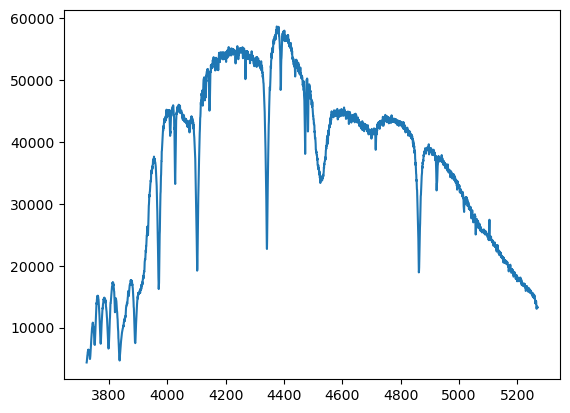

In [27]:
plt.plot(_starspec.wave, _starspec.dumpdic['spec_extr'][::-1])